In [1]:
import torch

In [2]:
torch.__version__

'0.4.0'

In [3]:
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from itertools import chain
from cub_data import *
import pandas as pd
from tqdm import tqdm

In [4]:
%matplotlib inline

In [5]:
device = torch.device('cpu')

In [6]:
def to_var(x):
#     if torch.cuda.is_available():
#         x = x.cuda()
    global device
    return x.to(device)

def idx2onehot(idx, n):

    assert idx.size(1) == 1
    assert torch.max(idx).data[0] < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)
    onehot = to_var(onehot)
    
    return onehot

MSE recon_loss is not good. I think because on training the svm with generated examples of 200 categories, it gave 100% acc on those examples and 32% acc on real training data.
##### Try MAE
##### Try Cosine
##### Try changing latent size

In [7]:
class VAE(nn.Module):

    def __init__(self, encoder_layer_sizes, latent_size, decoder_layer_sizes, regressor_layer_sizes, attributes):

        super().__init__()

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list

        self.latent_size = latent_size
        self.num_labels = attributes.shape[0]
        self.attribute_size = attributes.shape[1]
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(attributes))

        
        self.encoder = Encoder(encoder_layer_sizes, latent_size, self.num_labels)
        self.decoder = Decoder(decoder_layer_sizes, latent_size, self.attribute_size, self.embeddings)
        self.regressor = Regressor(regressor_layer_sizes, attributes)
        
        """
        Grouping the model's parameters: separating encoder, decoder, and discriminator
        """
        self.encoder_params = chain(
            self.encoder.parameters()
        )

        self.decoder_params = chain(
            self.decoder.parameters()
        )

        self.vae_params = chain(
            self.encoder_params, self.decoder_params
        )
        self.vae_params = filter(lambda p: p.requires_grad, self.vae_params)

        self.regressor_params = filter(lambda p: p.requires_grad, self.regressor.parameters())
        
    def sample_z(self, mu, logvar):
        """
        Reparameterization trick: z = mu + std*eps; eps ~ N(0, I)
        """
        batch_size = mu.size(0)
        eps = to_var(torch.randn([batch_size, self.latent_size]))
        return mu + torch.exp(logvar/2) * eps

    def sample_z_prior(self, bsize):
        """
        Sample z ~ p(z) = N(0, I)
        """
        z = to_var(torch.randn(bsize, self.latent_size))
        return z

    def sample_c_prior(self, bsize):
        """
        Sample c ~ p(c) = Cat([0.5, 0.5])
        """
        c = to_var(
            torch.LongTensor(np.random.randint(0, self.num_labels, (bsize,1)))
        )
        return c

    def forward(self, x, c=None):
        """
        Params:
        -------
        c: whether to sample `c` from prior or use what is provided.
        Returns:
        --------
        recon_loss: reconstruction loss of VAE.
        kl_loss: KL-div loss of VAE.
        """
        batch_size = x.size(0)

        means, log_var = self.encoder(x)

        z = self.sample_z(means, log_var)

        if c is None:
            c = self.sample_c_prior(batch_size)
        
        recon_x = self.decoder(z, c)
        
        recon_loss = F.l1_loss(recon_x, x, size_average=False)
        kl_loss = torch.sum(0.5 * torch.sum(torch.exp(log_var) + means**2 - 1 - log_var, 1))

        return recon_loss, kl_loss

    def synthesize_examples(self, n=1):

        batch_size = n
        z = self.sample_z_prior(batch_size)
        c = self.sample_c_prior(batch_size)
        
        recon_x = self.decoder(z, c)

        return recon_x



class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, num_labels):

        super().__init__()

        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate( zip(layer_sizes[:-1], layer_sizes[1:]) ):
            self.MLP.add_module(name="L%i"%(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A%i"%(i), module=nn.ReLU())
#             self.MLP.add_module(name="BN%i"%(i), module=nn.BatchNorm1d(out_size))


        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x):

        x = self.MLP(x)

        means = self.linear_means(x)
        log_vars = torch.log(F.softplus(self.linear_var(x)))
#         log_vars = self.linear_var(x)

        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, attribute_size, embeddings):

        super().__init__()
    
        self.embeddings = embeddings
        self.MLP = nn.Sequential()

        input_size = latent_size + attribute_size

        for i, (in_size, out_size) in enumerate( zip([input_size]+layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(name="L%i"%(i), module=nn.Linear(in_size, out_size))
            if i+1 < len(layer_sizes):
                self.MLP.add_module(name="A%i"%(i), module=nn.ReLU())
#                 self.MLP.add_module(name="BN%i"%(i), module=nn.BatchNorm1d(out_size))
            else:
                pass

    def forward(self, z, c):
        
        a = self.embeddings(c.view(-1))
        z = torch.cat((z, a), dim=-1)

        x = self.MLP(z)

        return x
    
class Regressor(nn.Module):

    def __init__(self, layer_sizes, attributes):

        super().__init__()

        self.num_labels = attributes.shape[0]
        self.attribute_size = attributes.shape[1]
        self.attributes = to_var(torch.FloatTensor(attributes))
        self.attributes = self.attributes.view((1, self.num_labels, self.attribute_size))
        
        self.MLP = nn.Sequential()
        i=0
        for i, (in_size, out_size) in enumerate( zip(layer_sizes[:-1], layer_sizes[1:]) ):
            self.MLP.add_module(name="L%i"%(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A%i"%(i), module=nn.ReLU())
#             self.MLP.add_module(name="BN%i"%(i), module=nn.BatchNorm1d(out_size))

        self.MLP.add_module(name="L%i"%(i+1), module=nn.Linear(layer_sizes[-1], self.attribute_size))

    def forward(self, x):

        a = self.MLP(x)
        # Reshape predicted attribute because broadcasting is not supported
        # a has shape               batch_size x   1 x 312
        # attributes have shape:             1 x 200 x 312
        a = a.view((-1, 1, self.attribute_size))
        # logits of shape:          batch_size x 200
        logits = nn.CosineSimilarity(dim=2, eps=1e-6)(a, self.attributes)
        # log of predictions shape: batch_size x 200
        c_hat = F.log_softmax(logits, dim=-1)
        return c_hat

In [8]:
data = CUB_data('../../../Downloads/xlsa17/data/CUB/att_splits.mat', '../../../Downloads/xlsa17/data/CUB/res101.mat')

In [9]:
model = VAE([2048, 512, 512], 78, [512, 2048], [2048, 512], data.class_attributes).to(device)

In [10]:
model

VAE(
  (embeddings): Embedding(200, 312)
  (encoder): Encoder(
    (MLP): Sequential(
      (L0): Linear(in_features=2048, out_features=512, bias=True)
      (A0): ReLU()
      (L1): Linear(in_features=512, out_features=512, bias=True)
      (A1): ReLU()
    )
    (linear_means): Linear(in_features=512, out_features=78, bias=True)
    (linear_var): Linear(in_features=512, out_features=78, bias=True)
  )
  (decoder): Decoder(
    (embeddings): Embedding(200, 312)
    (MLP): Sequential(
      (L0): Linear(in_features=390, out_features=512, bias=True)
      (A0): ReLU()
      (L1): Linear(in_features=512, out_features=2048, bias=True)
    )
  )
  (regressor): Regressor(
    (MLP): Sequential(
      (L0): Linear(in_features=2048, out_features=512, bias=True)
      (A0): ReLU()
      (L1): Linear(in_features=512, out_features=312, bias=True)
    )
  )
)

In [11]:
X_train, c_train = data.sets['trainval_X'], data.sets['trainval_a']

In [12]:
def train_vae(optimizer, epoch):
    batch_size = 128
    n = len(X_train)
    model.train()
    
    beta = 1 * epoch/40
#     beta = 1
    
    avg_loss = 0
    for i in tqdm(range(0,n, batch_size)):
        x, c = X_train[i:i+batch_size], c_train[i:i+batch_size]
        x, c = torch.FloatTensor(x).to(device), torch.LongTensor(c).to(device)
        recon_loss, kl_loss  = model.forward(x,c)
        loss = recon_loss + beta*kl_loss
        
        avg_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss /= n
    return avg_loss

def validate_vae():
    model.eval()
    batch_size = 32
    n = len(X_val)
    avg_loss = 0
    for i in range(0,n, batch_size):
        x, c = X_val[i:i+batch_size], c_val[i:i+batch_size]
        x, c = torch.FloatTensor(x).to(device), torch.LongTensor(c).to(device)
        recon_loss, kl_loss  = model.forward(x,c)
        loss = recon_loss + kl_loss
        
        avg_loss += loss.item()
        
    avg_loss /= n
    return avg_loss

One batch takes 22 ms on cpu, whereas 3 ms on gpu

In [13]:
def alternating_training(optimizer_R, optimizer_V, epoch, total_epoch):
    lambda_r = 0.1
    lambda_c = 0.1
    lambda_reg = 0.1
    lambda_e = 0.1

    batch_size = 128
    n = len(X_train)
    n = n - (n % batch_size)
    model.train()

    avg_R_loss = 0
    avg_V_loss = 0
    
    beta = 1
    
    for i in range(0,n, batch_size):
        x, c = X_train[i:i+batch_size], c_train[i:i+batch_size]
        x, c = torch.FloatTensor(x).to(device), torch.LongTensor(c).to(device)

        """ Update regressor, eq. 3 """
        c_real  = model.regressor.forward(x)

        z_gen, c_gen = model.sample_z_prior(batch_size) , model.sample_c_prior(batch_size)
        x_gen = model.decoder.forward(z_gen, c_gen)
        c_fake  = model.regressor.forward(x_gen)

        loss_s = F.cross_entropy(c_real, c.view(-1), size_average=False)
        loss_u = F.cross_entropy(c_fake, c_gen.view(-1), size_average=False)
        loss_R = loss_s + lambda_r*loss_u

        loss_R.backward()
        optimizer_R.step()
        optimizer_R.zero_grad()
        avg_R_loss += loss_R.item()

    for i in tqdm(range(0,n, batch_size)):
        x, c = X_train[i:i+batch_size], c_train[i:i+batch_size]
        x, c = torch.FloatTensor(x).to(device), torch.LongTensor(c).to(device)

        """ Update vae, eq. 8 """
        means, log_var = model.encoder.forward(x)
        z = model.sample_z(means, log_var)
        x_hat = model.decoder.forward(z, c)

        mu, logvar = model.encoder.forward(x_hat)
        z_hat = model.sample_z(mu, logvar)
        c_hat = model.regressor.forward(x_hat)

        z_gen2 = model.sample_z_prior(batch_size)
        x_gen2 = model.decoder.forward(z_gen2, c)

        loss_vae = F.l1_loss(x_hat, x, size_average=False) + \
                    beta*torch.sum(0.5 * torch.sum(torch.exp(log_var) + means**2 - 1 - log_var, 1))

        loss_c = F.cross_entropy(c_hat, c.view(-1), size_average=False)

        loss_reg = F.l1_loss(x_gen2, x_hat, size_average=False)

        loss_e = F.mse_loss(z_gen2, z, size_average=False)

        loss_V = loss_vae + lambda_c*loss_c + lambda_reg*loss_reg + lambda_e*loss_e

        loss_V.backward()
        optimizer_V.step()
        optimizer_V.zero_grad()

        avg_V_loss += loss_V.item()
    
    avg_R_loss /= n
    avg_V_loss /= n
    return avg_R_loss, avg_V_loss

def alternating_validation():

    lambda_r = 0.1
    lambda_c = 0.1
    lambda_reg = 0.1
    lambda_e = 0.1

    batch_size = 128
    n = len(X_val)
    n = n - (n % batch_size)
    model.eval()

    avg_R_loss = 0
    avg_V_loss = 0
    
    for i in range(0,n, batch_size):
        x, c = X_val[i:i+batch_size], c_val[i:i+batch_size]
        x, c = torch.FloatTensor(x).to(device), torch.LongTensor(c).to(device)

        """ Obtain regressor loss, eq. 3 """
        c_real  = model.regressor.forward(x)

        z_gen, c_gen = model.sample_z_prior(batch_size) , model.sample_c_prior(batch_size)
        x_gen = model.decoder.forward(z_gen, c_gen)
        c_fake  = model.regressor.forward(x_gen)

        loss_s = F.cross_entropy(c_real, c.view(-1))
        loss_u = F.cross_entropy(c_fake, c_gen.view(-1))
        loss_R = loss_s + lambda_r*loss_u


        """ Obtain vae loss, eq. 8 """
        means, log_var = model.encoder.forward(x)
        z = model.sample_z(means, log_var)
        x_hat = model.decoder.forward(z, c)

        mu, logvar = model.encoder.forward(x_hat)
        z_hat = model.sample_z(mu, logvar)
        c_hat = model.regressor.forward(x_hat)

        z_gen2 = model.sample_z_prior(batch_size)
        x_gen2 = model.decoder.forward(z_gen2, c)

        loss_vae = F.l1_loss(x_hat, x, size_average=True) + \
                    torch.mean(0.5 * torch.sum(torch.exp(log_var) + means**2 - 1 - log_var, 1))

        loss_c = F.cross_entropy(c_hat, c.view(-1))

        loss_reg = F.l1_loss(x_gen2, x_hat, size_average=True)

        loss_e = F.mse_loss(z_gen2, z, size_average=True)

        loss_V = loss_vae + lambda_c*loss_c + lambda_reg*loss_reg + lambda_e*loss_e

        avg_R_loss += loss_R.data.numpy().reshape(1)[0]
        avg_V_loss += loss_V.data.numpy().reshape(1)[0]
    
    avg_R_loss /= n
    avg_V_loss /= n
    return avg_R_loss, avg_V_loss

One batch takes 37 ms on cpu

In [14]:
lr = 0.001
optimizer_R = optim.Adam(model.regressor_params, lr=lr)
optimizer_V = optim.Adam(model.vae_params, lr=0.001)

In [15]:
df = pd.DataFrame([[np.NaN]], columns=['loss'])
total_epochs = 40
for epoch in range(total_epochs):
    res = {}
    res['loss'] = train_vae(optimizer_V, epoch)
#     res['val_loss'] = validate_vae()
    df = df.append(pd.Series(res), ignore_index=True)
    df.to_csv('vae_train_29.csv')

100%|██████████| 56/56 [00:55<00:00,  1.01it/s]


In [17]:
lr = 0.0001
for param_group in optimizer_R.param_groups:
        param_group['lr'] = lr*10
        
for param_group in optimizer_V.param_groups:
        param_group['lr'] = lr

In [18]:
total_epochs = 10
for epoch in range(total_epochs):
    res = {}
    res['loss'] = train_vae(optimizer_V, epoch)
#     res['val_loss'] = validate_vae()
    df = df.append(pd.Series(res), ignore_index=True)
    df.to_csv('vae_train_28.csv')

100%|██████████| 56/56 [00:09<00:00,  5.81it/s]


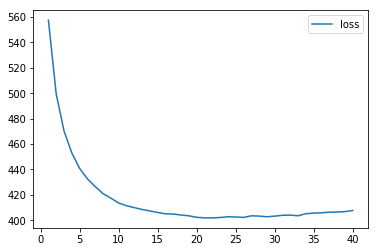

In [16]:
df.iloc[1:].plot()

In [16]:
lr = 0.0001
for param_group in optimizer_R.param_groups:
        param_group['lr'] = lr*10
        
for param_group in optimizer_V.param_groups:
        param_group['lr'] = lr

In [17]:
df = pd.DataFrame([[np.NaN,np.NaN]], columns=['r_loss', 'v_loss'])
for epoch in range(40):
    res = {}
    res['r_loss'], res['v_loss'] = alternating_training(optimizer_R, optimizer_V, epoch, 20)
#     res['val_r_loss'], res['val_v_loss'] = alternating_validation()
    df = df.append(pd.Series(res), ignore_index=True)
    df.to_csv('vae_train_29_1.csv')

100%|██████████| 55/55 [02:07<00:00,  2.32s/it]


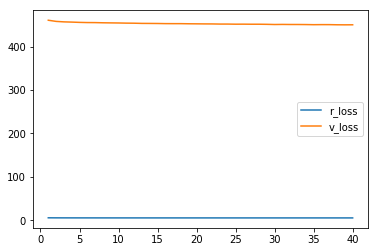

In [18]:
df.iloc[:].plot()

##### model weights: vae_10_10.pt (10 10 epochs)  32% acc on training data using generated data
##### vae_2_20_5.pt  (2 20 5 epochs) 5 at 0.0001 lr  39.25% acc  s2t 67.7%  u2t 2.32%
##### vae_l1_2_10_5.pt (2 10 5 epochs) l1_loss instead of mse_loss for reconstructed input  37.22% acc, s2t acc 68.25% u2t 5.8%
##### vae_cos_1_10_5.pt (1 10 5 epochs) negative cosine similarity 14.02% acc
##### vae_l1_2_1_10_10.pt (1 10 10 epochs) l1 for recon_loss with proper alternating training  ss2t acc 68.36% u2t 3.77%
##### class_weights were incorrect. Calculating accuracy again
##### vae_relu_l1_2_10_10.pt (2 10 10 epochs) replaced tanh with relu, using trainval_loc (150 seen classes instead of 100) 44.29% acc (batch_size 40)  52% acc (batch size 200). There are two parameters of SVM: fit_intercept and class_weight. Removing class_weight increases unseen accuracy to 12%

##### vae_relu_l1_2_2_10_10.pt Increasing batch size from 32 to 128. 45.8% acc (trainval) 38.49% (test_seen) 17% (test_unseen)
##### vae_relu_l1_logsig_2_10_10.pt Changed log_softmax to logsigmoid in regressor. 46.9% (trainval) 39.45% (test seen) 15% (test unseen)
##### vae_relu_l1_3_2_10_10.pt Increasing batch size from 128 to 200. 40% (trainval) 34% (test seen) 17% (test unseen)
##### vae_relu_l1_4_2_10.pt batch size 128. latent size 4 48.91% (trainval) 41.32% (test seen) 15.63% (test unseen)
##### vae_relu_l1_5_1_10.pt batch size 128. latent size 2 43.03% (trainval) 37.13% (test seen) 15.8% (test unseen)
##### vae_relu_l1_6_1_10_10.pt lr 10 0.01 then 0.01 latent size 2 0.6% (trainval) 0.8% (test seen) 0% (test unseen)
##### vae_relu_l1_7_2_10.pt lr 0.001 then 0.0001 latent size 2 lambda(s)=0.5  42.6% (trainval) 33.9% (test seen) 14.49% (test unseen)
##### vae_relu_l1_softplus_2_10.pt 47.9% (trainval) 40.6% (test seen) 15.3% (test unseen)
##### vae_relu_l1_bn_softplus_2_10.pt  0.11% (trainval) 0.17% (test seen) 1% (test unseen)
##### vae_relu_l1_bn_softplus_10_10.pt  gradually increasing kl_loss
##### vae_relu_l1_bn_softplus_100_10.pt  gradually increasing kl_loss at lr 0.0001
##### vae_relu_l1_bn_softplus_4e-1_100_10.pt beta is 0.4 instead of 1 (previously)
##### vae_relu_l1_bn_softplus_4e-1_100_10_2.pt latent size back to 64 1.1% (trainval) 1.1% (test seen) 0.2% (test unseen)
##### vae_relu_l1_bn_softplus_4e-1_5_10_3.pt batchnorm affine=False 0.53% (trainval) 0.39% (test seen) 0.13% (test unseen)
##### vae_lrelu_l1_softplus_4e-1_80_10_4.pt removed batch_norm  still very less acc
##### vae_l1_softplus_20_10_1.pt lrelu, relu, softplus 2 layers everywhere
##### vae_l1_softplus_20_20_2.pt gradually increasing all losses  10% (test seen) 0% (test unseen)
##### vae_l1_softplus_20_20_20_20.pt gradually increasing all losses then again restarting
##### vae_l1_softplus_20_20_20_20_2.pt completely removing batch norm increasing e and c loss while decreasing kl loss
##### vae_l1_softplus_20_20_20_20_3.pt training the vae without kl loss for first 20 epochs.
##### vae_small_2_10 relu 1 hidden layer encoder, total 1 layer for decoder and regressor
##### vae_small_70 2 hidden layer 70 epochs at 0.0001 lr 8% (test unseen)
##### vae_small_relu_bn 2 hidden layer 30 epoch 0.28% (test seen) 0.03% (test unseen)
##### vae_relu_10_10  10 epoch at 0.001 lr and 10 epoch at 0.0001 lr (seems to converge) log of softplus of var 32.9% (trainval) 29.7% (test seen) 17.29% (test unseen)
##### vae_relu_10_10_20 40% (trainval) 35% (test seen) 20% (test unseen)  47.9% (u->u)
##### vae_relu_wu 35.35% (u->u)

In [17]:
torch.save(model.state_dict(), 'weights/vae_relu_wu_40_20.pt')

In [15]:
model.load_state_dict(torch.load('weights/vae_relu_wu.pt'))

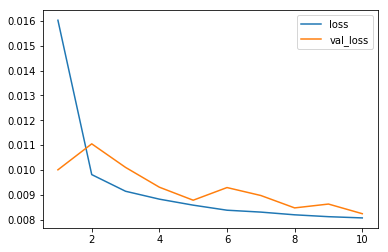

In [15]:
df.iloc[1:].plot()

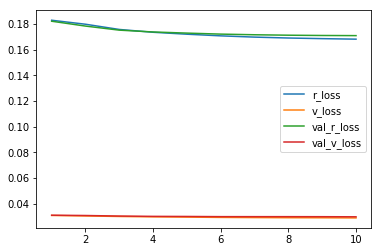

In [26]:
df.iloc[:].plot()

In [ ]:
df = pd.read_csv('vae_train_70.csv', index_col=0)